In [118]:
# General Python
import sys
import os
sys.path.append('./')


# Data structures
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
dpi = 200
mpl.rc("savefig", dpi=dpi)
%matplotlib inline
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
from scipy import stats
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import seaborn as sns
import math
import re

from lmfit import minimize, Parameters, report_fit
from matplotlib.colors import LogNorm

#additional imports
import pandas as pd
from Bio import SeqIO, SeqRecord,Seq
import mkl_random
import random

import os
import subprocess
from Bio import Entrez, SeqIO
from copy import deepcopy
from pathlib import Path

import datetime
import time
import json
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

import seaborn as sb

import re


## 1. Import csvs from mutant calling notebook

In [204]:
#import dataframe containing lists of mutants with single AA substitutions
combinedDF=pd.read_csv('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/mutant_calling/csv_files/plates_1-13_mutant_calling_all_AA_subs.csv')

## 2. Create DF to start adding per plate stats

In [205]:
perPlateStatsDF=pd.DataFrame()

## 3. Generate dataframes with variants 1, 2, 3 or more substitutions, and calculate per plate

In [206]:
#Make list of plate numbers
platesL=np.arange(1,14)

#make lists to store stats
singlesCountL=[]  #number of unique singles per plate, note this has to be separated into intended/unintended later
doublesCountL=[] #number of BCs containing 2 variants
triplesCountL=[] #Number of BCs containing 3 or more variants

#loop through list and get data for each plate
for i in platesL:
    
    #select only rows from plate i
    tempDF=combinedDF.loc[combinedDF['plate']==i]
    
    #get barcodes with only one variant
    singlesDF=tempDF.groupby('i7_barcode').filter(lambda x: len(x) < 2)
    singlesCount=singlesDF['i7_barcode'].nunique()
    singlesCountL.append(singlesCount)

    #get barcodes with two variants
    doublesDF=tempDF.groupby('i7_barcode').filter(lambda x: len(x) == 2)
    doublesCount=doublesDF['i7_barcode'].nunique()
    doublesCountL.append(doublesCount)

    #get triples
    triplesDF=tempDF.groupby('i7_barcode').filter(lambda x: len(x) > 2)
    triplesCount=triplesDF['i7_barcode'].nunique()
    triplesCountL.append(triplesCount)

#add stats to DF
perPlateStatsDF['plate']=platesL
perPlateStatsDF['total']=[40,48,48,48,47,47,47,30,46,46,43,26,25]
perPlateStatsDF['single_all_num']=singlesCountL
perPlateStatsDF['double_num']=doublesCountL
perPlateStatsDF['triple_num']=triplesCountL  

In [207]:
print(combinedDF['i7_barcode'].nunique())
#get barcodes with only one variant
singlesDF=combinedDF.groupby('i7_barcode').filter(lambda x: len(x) < 2)
# singlesDF=singlesDF.loc[singlesDF['ratio_var']>100]
print(singlesDF['i7_barcode'].nunique())

#get barcodes with two variants
doublesDF=combinedDF.groupby('i7_barcode').filter(lambda x: len(x) == 2)
print(doublesDF['i7_barcode'].nunique())

triplesDF=combinedDF.groupby('i7_barcode').filter(lambda x: len(x) > 2)
print(triplesDF['i7_barcode'].nunique())

3029
2056
761
212


## 4. Determine which single substitutions are intended vs unintended, and calculate per plate

In [208]:
#import DF containing all singles classified by intended/unintended
singlesDF_classified=pd.read_csv('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/mutant_calling/csv_files/single_mutant_csvs/20210603_singles_2056_total_1996_intended_507_unique_0_threshold.csv')

#calculate number of intended vs unintended
print("unintended:")
numUNintended= len(singlesDF_classified.loc[singlesDF_classified['intended']==False])
print(numUNintended)
print("intended:")
numIntended= len(singlesDF_classified.loc[singlesDF_classified['intended']==True])
print(numIntended)

#calculate number of unique singles that were intended
intendedOnlyDF=singlesDF_classified.loc[singlesDF_classified['intended']==True]
numUnique=intendedOnlyDF['amino_acid_sub'].nunique()
print("unique:")
print(numUnique)

unintended:
60
intended:
1996
unique:
507


In [209]:
#Make list of plate numbers
platesL=np.arange(1,14)

#make lists to store stats
intendedCountL=[]  #number of singles with intended sub
intendedUniqueCountL=[]  #number of unique singles with intended sub
unintendedCountL=[] #number of singles with unintended sub
unintendedUniqueCountL=[]  #number of unique singles with intended sub

#loop through list and get data for each plate
for i in platesL:
    
    #select only rows from plate i
    tempDF=singlesDF_classified.loc[singlesDF_classified['plate']==i]
    
    #get total count of intended singles
    intendedCount=(tempDF.loc[tempDF['intended']==True])['i7_barcode'].nunique()
    intendedCountL.append(intendedCount)
    
    #get count of unique intended singles
    intendedUniqueCount=(tempDF.loc[tempDF['intended']==True])['amino_acid_sub'].nunique()
    intendedUniqueCountL.append(intendedUniqueCount)

    #get total count of unintended singles
    unintendedCount=(tempDF.loc[tempDF['intended']==False])['i7_barcode'].nunique()
    unintendedCountL.append(unintendedCount)
       
    #get count of unique unintended singles
    unintendedUniqueCount=(tempDF.loc[tempDF['intended']==False])['amino_acid_sub'].nunique()
    unintendedUniqueCountL.append(unintendedUniqueCount)
    
#add stats to DF
perPlateStatsDF['singles_intended_total']=intendedCountL
perPlateStatsDF['singles_unintended_total']=unintendedCountL
perPlateStatsDF['singles_intended_unique']=intendedUniqueCountL
perPlateStatsDF['singles_unintended_unique']=unintendedUniqueCountL
perPlateStatsDF

,plate,total,single_all_num,double_num,triple_num,singles_intended_total,singles_unintended_total,singles_intended_unique,singles_unintended_unique
0,1,40,178,61,18,175,3,37,3
1,2,48,154,66,17,148,6,46,6
2,3,48,168,65,20,161,7,47,7
3,4,48,135,43,27,131,4,45,3
4,5,47,175,85,11,169,6,46,6
5,6,47,141,60,23,138,3,44,3
6,7,47,141,59,12,134,7,41,5
7,8,30,94,21,5,91,3,27,3
8,9,46,148,50,11,142,6,40,6
9,10,46,210,81,24,204,6,43,6


### Import DF containing indel subs and count for each plate

In [210]:
indelDF=pd.read_csv('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/mutant_calling/csv_files/plates_1-13_mutant_calling_indels.csv')

In [211]:
#Make list of plate numbers
platesL=np.arange(1,14)

#make lists to store stats
indelCountL=[]  #number of barcodes containing indels in plate

#loop through list and get data for each plate
for i in platesL:
    
    #select only rows from plate i
    tempDF=indelDF.loc[indelDF['plate']==i]
    
    #get total count of intended singles
    indelCount=tempDF['i7_barcode'].nunique()
    indelCountL.append(indelCount)
    
#add stats to DF
perPlateStatsDF['indels_(total_BCs)']=indelCountL
perPlateStatsDF

,plate,total,single_all_num,double_num,triple_num,singles_intended_total,singles_unintended_total,singles_intended_unique,singles_unintended_unique,indels_(total_BCs)
0,1,40,178,61,18,175,3,37,3,20
1,2,48,154,66,17,148,6,46,6,8
2,3,48,168,65,20,161,7,47,7,14
3,4,48,135,43,27,131,4,45,3,24
4,5,47,175,85,11,169,6,46,6,21
5,6,47,141,60,23,138,3,44,3,23
6,7,47,141,59,12,134,7,41,5,5
7,8,30,94,21,5,91,3,27,3,2
8,9,46,148,50,11,142,6,40,6,16
9,10,46,210,81,24,204,6,43,6,7


### Import DF containing list of BCs corresponding to WT (meeting read thresholds), count those belonging to each plate

In [212]:
#import CSV containing barcodes with WT
WTbarcodesDF=pd.read_csv('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/mutant_calling/csv_files/20210603_plates_1-13_barcodes_WT_327.csv')

#import csv containing plate-well data to add plate column to this DF
barcodeKeyDF=pd.read_csv('/Users/mja/Appel_MutSequencing/Barcodes/20201212_MJA_1-13_plate_well_key.csv')
barcodeKeyDF.rename(columns={"i7": "i7_barcode"}, inplace=True)

#merge
WTbarcodePlateDF= pd.merge(left=WTbarcodesDF, right=barcodeKeyDF, left_on='i7_barcode', right_on='i7_barcode')

In [213]:
#Make list of plate numbers
platesL=np.arange(1,14)

#make lists to store stats
WTcountL=[]  #number of barcodes containing indels in plate

#loop through list and get data for each plate
for i in platesL:
    
    #select only rows from plate i
    tempDF=WTbarcodePlateDF.loc[WTbarcodePlateDF['plate']==i]
    
    #get total count of intended singles
    WTcount=tempDF['i7_barcode'].nunique()
    WTcountL.append(WTcount)
    
#add stats to DF
perPlateStatsDF['WT']=WTcountL
perPlateStatsDF

,plate,total,single_all_num,double_num,triple_num,singles_intended_total,singles_unintended_total,singles_intended_unique,singles_unintended_unique,indels_(total_BCs),WT
0,1,40,178,61,18,175,3,37,3,20,41
1,2,48,154,66,17,148,6,46,6,8,29
2,3,48,168,65,20,161,7,47,7,14,31
3,4,48,135,43,27,131,4,45,3,24,18
4,5,47,175,85,11,169,6,46,6,21,23
5,6,47,141,60,23,138,3,44,3,23,17
6,7,47,141,59,12,134,7,41,5,5,24
7,8,30,94,21,5,91,3,27,3,2,24
8,9,46,148,50,11,142,6,40,6,16,35
9,10,46,210,81,24,204,6,43,6,7,30


In [214]:
perPlateStatsDF.set_index('plate', inplace=True)

In [215]:
#add column calculating sum of total number of barcodes meeting depth of >=1 read at all positions and >= 10X coverage at 95% of positions
perPlateStatsDF['BCs_meeting_depth']=perPlateStatsDF['single_all_num']+perPlateStatsDF['double_num']+perPlateStatsDF['triple_num']+perPlateStatsDF['indels_(total_BCs)']+perPlateStatsDF['WT']

In [216]:
perPlateStatsDF

,total,single_all_num,double_num,triple_num,singles_intended_total,singles_unintended_total,singles_intended_unique,singles_unintended_unique,indels_(total_BCs),WT,BCs_meeting_depth
plate,,,,,,,,,,,
1,40,178,61,18,175,3,37,3,20,41,318
2,48,154,66,17,148,6,46,6,8,29,274
3,48,168,65,20,161,7,47,7,14,31,298
4,48,135,43,27,131,4,45,3,24,18,247
5,47,175,85,11,169,6,46,6,21,23,315
6,47,141,60,23,138,3,44,3,23,17,264
7,47,141,59,12,134,7,41,5,5,24,241
8,30,94,21,5,91,3,27,3,2,24,146
9,46,148,50,11,142,6,40,6,16,35,260


### Export DF with per plate library content stats

In [217]:
perPlateStatsDF.to_csv('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/mutant_calling/csv_files/per-plate-lib-content-stats/20210611_plates_1-13_per_plate_content_stats.csv')

### Get counts of intended single mutations at all positions, organized per sublibrary

In [229]:
#define sublibrary boundaries
mutationD={1:[2,41],
           2:[42,89],
           3:[90,137],
           4:[138,185],
           5:[186,232],
           6:[233,279],
           7:[280,326],
           8:[327,356],
           9:[357,402],
           10:[403,448],
           11:[449,491],
           12:[492,517],
           13:[518,542]
          }

#make dict to store positional frequencies for each sublibrary (this will be a dict of dicts)
sublibFreqD={}

#determine counts of each intended single mutant in each sublibary, create dict with counts for all positions
for i, j in mutationD.items():
    
    #make list of positions in this sublibary window
    codonL=np.arange(j[0],j[1]+1)
        
    #select only rows from plate i
    tempDF=singlesDF_classified.loc[singlesDF_classified['plate']==i]
    
    #get total count of intended singles
    intendedTempDF=tempDF.loc[tempDF['intended']==True]
    
    #get list of unique codons mutated in this sublibrary
    obsCodonsL=intendedTempDF['codon'].unique()
    
    #get dict of counts per position
    countsD=(intendedTempDF['codon'].value_counts(ascending=True)).to_dict()

    for codon in codonL:
        if codon not in obsCodonsL:
            countsD[codon]=0
        else:
            pass
    
    #sort dictionary in codon ascending order, add to dict for all sublibaries
    sublibFreqD[i] = dict(sorted(countsD.items(), key=lambda item: item[0])) 

In [290]:
#convert this dictionary to a DF and export
#format will be: index= codon position, columns = sublibraries 1-13, and column values = counts incl 0 for all positions
#codons outside the sublibrary will return NaN, must drop these later when getting data per sublibrary
# see below
# 	1	2	3	4	5	6	7	8	9	10	11	12	13
# 2	5.0	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN
# 3	7.0	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN
# 4	3.0	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN
# 5	3.0	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN
# 6	5.0	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN

sublibFreqD_DF=pd.DataFrame(sublibFreqD)
sublibFreqD_DF.index.set_names('position', inplace=True)
sublibFreqD_DF.to_csv('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/mutant_calling/csv_files/singles_total_per_position/20210615_plates_1-13_singles_per_pos_2-542.csv')

### Use dict containing per-sublibrary per-position mutational counts to get frequency distributions

0.5611484781813366


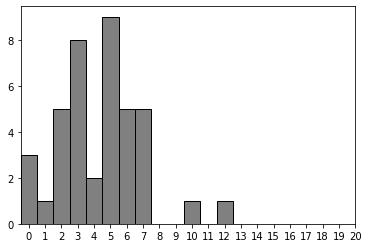

0.8652164663727604


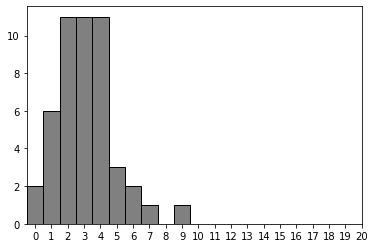

0.48830901600061977


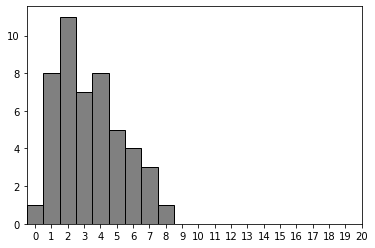

0.763560846720106


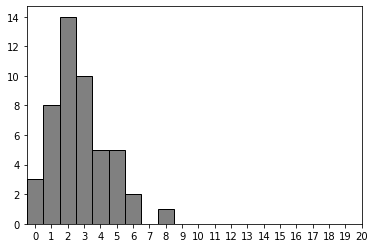

1.2196023486381757


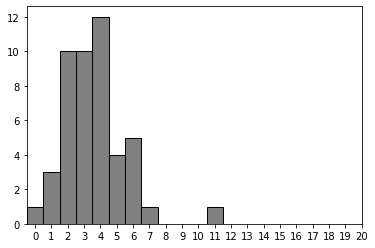

0.47147094436532383


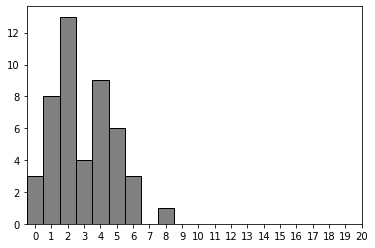

5.217495587299972


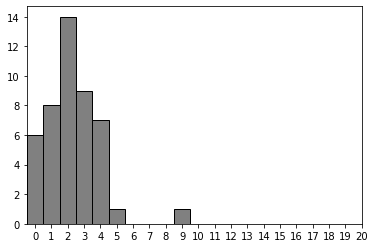

0.25721364688093024


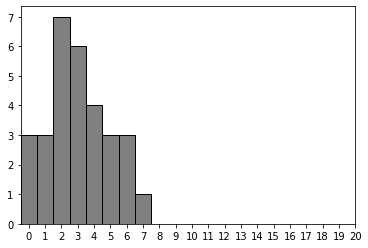

0.0636939413706356


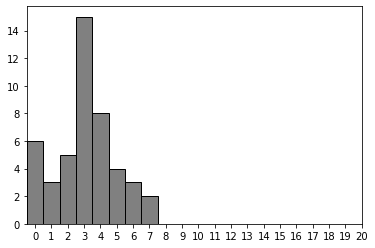

0.22507396888489942


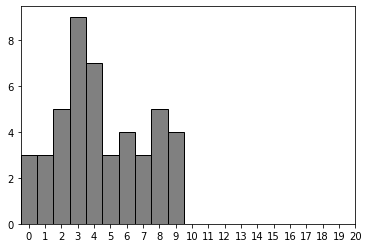

1.063225982290583


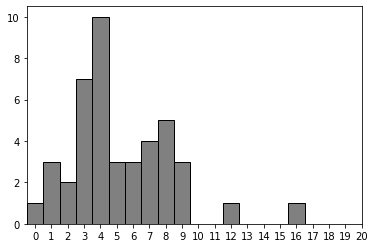

-0.09978147465304292


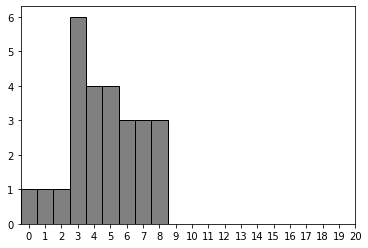

-0.2622546869808326


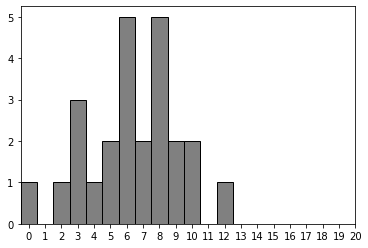

<Figure size 432x288 with 0 Axes>

In [271]:
for j,k in sublibFreqD.items():
    freqL=list(k.values())
    print(stats.skew(freqL, axis=0, bias=True, nan_policy='propagate'))
    plt.hist(freqL, bins = np.arange(-0.5,20.5,1), color='gray',edgecolor='k')
    plt.xlim(-0.5,20)
    plt.xticks(np.arange(0,21,1))
    plt.show()
    plt.clf()

In [270]:
stats.skew(freqL, axis=0, bias=True, nan_policy='propagate')

-0.2622546869808326